# n-step TD V(s) estimation/prediction
*   Monte Carlo (MC) waits full episode and makes changes to state/action functions via full return $G_t$ (lets call this quantity a _target_).
    $$G_t \dot = R_{t+1}+ \gamma R_{t+2} + \dots + \gamma^{T- t - 1}R_T$$ 
*   Temporal Differences with 1 step (TD(0)) updates estimate of functions based on immediate reward and estimate of next reward. 
    $$G_{t:t+1} \dot = R_{t+1}+ \gamma V_{t}(S_{t+1})$$
    So TD does estimate based on estimate, which is called bootstrapping. 
    
    It introduces a bias towards previous estimate of state/action function.

    Subscript $t$ in $V_{t}(S_{t+1})$ shows that algorithm uses expected state reward which is up-to-date at time $t$.
    
*   One can try to do updates of state/action functions using parts of episodes and get remaining expected rewards with old state/action function.

    For example using two steps:
    $$G_{t:t+2} \dot = R_{t+1}+ \gamma R_{t+2} +  \gamma^2 V_{t+1}(S_{t+2})$$

    It is still considered a bootstrapping because we do estimate based on estimate, although with lesser extend.

    Its obvious that at time $t$ algorithm does not know $R_{t+2}$, which is in the future, so it has to wait until $t+1$ to get it, and then might as well use most up-to-date $V_{t+1}$.
    
* In general we can analyze n state transitions of an episode, this approach is called _n-step TD method_

    $$G_{t:t+n} \dot = R_{t+1}+ \gamma R_{t+2} + \dots +  \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n -1}(S_{t+n})$$

    By similar logic as in two-step TD, $G_{t:t+n}$ can be evaluated only at $t+n-1$

*   n-step state-value update algorithm then is the following
$$V_{t+n}(S_t) \dot = V_{t+n-1}(S_t) + \alpha \bigg[ G_{t:t+n} - V_{t+n-1}(S_t) \bigg]$$

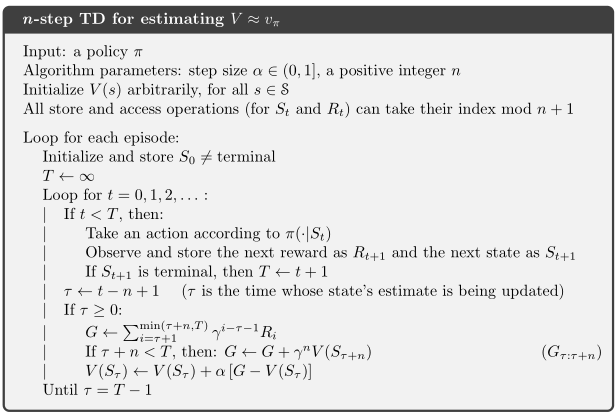

1.  Algorithm does n iterations until $t$ is $n$ steps past init which now can be backed up.
    $\tau$ is a counter for backe up state. It is negative at start, until $t = n-1$.<br>_($t$ is counted from 0)_
    $$\tau = 0 = t-n+1 \rightarrow t = n-1$$
    
2.  If Terminal state __is not__ reached in $n$ steps:
    1.  Algorithm will continue to loop $n$ steps ahead of initial state $t=0$, collecting new rewards.
    2.  Until that, $\tau$ block will be skipped. If $\tau = 0$:
    3.  Calculate $n$ steps of rewards ($G_{\tau:\tau+n}$)
    4.  Add rewards past $n$ steps as state value ($\gamma^n\cdot V(S_{\tau+n})$).
3.  If Terminal state __is__ reached faster than $n$ steps:
    1.  Set terminal time to next time step. !Next iterations will skip taking actions!
    2.  $\tau$ block will be skipped and main loop will continue until $t = n-1$
    3.  $G$ will be calculated with whatever trajectory there is
    4.  Because terminal state is reached, there is no need to add value state.
    
    Ignore next shit. this algo is overly convoluted. Could have covered early terminal state straight away.

    Although i think its needed this way because everything ill terminate at some point, and we need 'ghost' time steps to cover $n$ steps forward.

    %% For example for $n = 3$ terminal state reached at $t = 1$, so $T = 2$, $t = [0,1,2,3]$, $\tau = [-2,-1,0,1]$, $R = [0,R_1,R_2]$

    %% Algorithm will idle from $t = 1$ to $t = 2$ when $\tau$ becomes $0$

### What to expect:
Just policy evaluation. If policy is random then expect each episode to take many steps (-1 rewards)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs import (base_env, plot_cliff_walking, anim);
from IPython.display import clear_output
clear_output()
from misc_tools.print_latex import print_tex
plt.rcParams['figure.figsize'] = [4, 2]

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

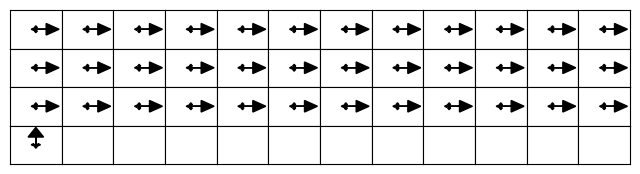

array([0.625, 0.125, 0.125, 0.125])

In [4]:
# completely random policy: epsilon = 1.
# env_nTD_V = base_env('FrozenLake-v1', desc=None, map_name="4x4", eps=1)

env_nTD_V = base_env("CliffWalking-v0", eps=0.5)
env_nTD_V.Qsa_init(random=False, action=1)
env_nTD_V.Qsa[37:] *= 0
env_nTD_V.Qsa[36] = [1,0,0,0]
env_nTD_V.policy_update_whole(use_Qsa = True)
env_nTD_V.policy[37:] *= 0
plot_cliff_walking(env_nTD_V.policy, figsize=(8,2))
env_nTD_V.policy[36]

100%|██████████| 2000/2000 [00:09<00:00, 215.16it/s]


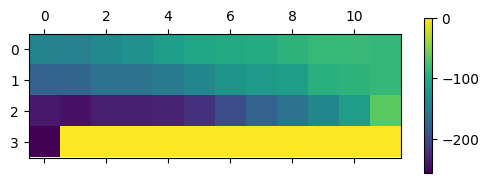

In [9]:
def n_step_TD_V(env: base_env, n_steps = 5, N = 1, GAMMA = 1, ALPHA = 0.01):

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        t = 0
        state           = env.reset()    
        mem = [state]
        rews = [-1000]  # dummy reward R_0 so next is R_{t+1}
        T = float("inf")
        while True:
            if t < T:
                action                      = env.sample_action(state, use_Qsa=False)
                state_prime, reward, done   = env.step(action)
                mem.append(state_prime)
                rews.append(reward)
                if done:
                    T = t + 1
                state = state_prime     # omg forgot this lool
            tau = t - n_steps + 1
            if tau >= 0:
                # add +1 to end range to include it.
                G = sum([GAMMA**(i-tau-1)*rews[i] for i in range(tau+1, min(tau+n_steps,T) + 1)])
                if tau + n_steps < T:
                    G += GAMMA**n_steps*env.Vs[mem[tau+n_steps]]
                env.Vs[mem[tau]] = env.Vs[mem[tau]] + ALPHA*(G - env.Vs[mem[tau]])
              
                #tq_iter.set_postfix(eps=env.eps, s = s)
            t += 1
            
            if tau == T - 1:
                break
    return

n_step_TD_V(env_nTD_V, n_steps = 5, N = 2000, GAMMA = 0.99, ALPHA = 0.01)
c = plt.matshow(env_nTD_V.Vs.reshape(4,12))
plt.colorbar(c)

## n-step SARSA


$$G_{t:t+n} = \underbrace{R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n-1} R_{t+n}}_{\text{n rewards}} + \gamma^n \underbrace{Q_{t+n-1}(S_{t+n}, A_{t+n})}_{\text{estimated future reward}}$$

Given that we dont take action from terminal state $Q(S_T,A_T)$, for $S_{t+n}$
$$0\leq t+n \lt T \longrightarrow 0 \leq t \lt T-n$$

Again, at time $t+n-1$ we make action and get reward $R_{t+n}$, so we use most up-to-date estimate $Q_{t+n-1}$

For early termination: $t + n \geq T$ (for example $n = 5$, termination after 2 steps: $t + 5 \geq T = t + 2$
$$G_{t:t+n} = G_t$$
Update rule:
$$Q_{t+n}(S_t,A_t) = Q_{t+n-1}(S_t,A_t) + \alpha \bigg[ G_{t:t+n} - Q_{t+n-1}(S_t,A_t)\bigg]$$

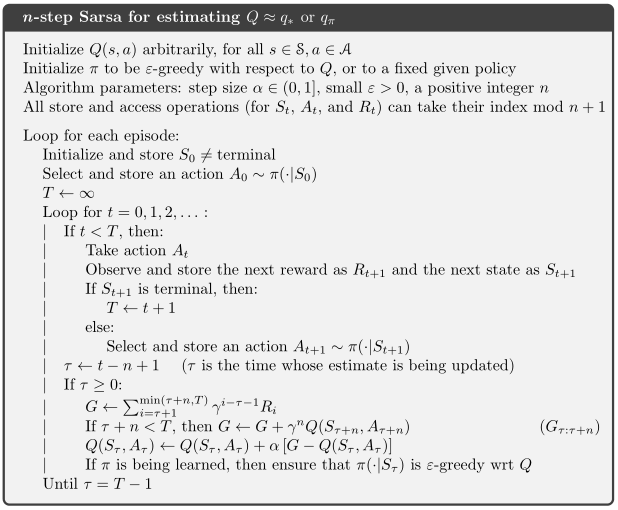

### What to expect
epsilon greedy policy -> safe 'optimal' trajectory

In [10]:
env_nSARSA_Q = base_env("CliffWalking-v0", eps=0.1)
env_nSARSA_Q.Qsa_init(random=False, action=1)
env_nSARSA_Q.Qsa[37:] *= 0
env_nSARSA_Q.Qsa[36] = [1,0,0,0]
#env_nSARSA_Q.policy_update_whole(use_Qsa = True)

  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 2000/2000 [00:06<00:00, 292.24it/s]


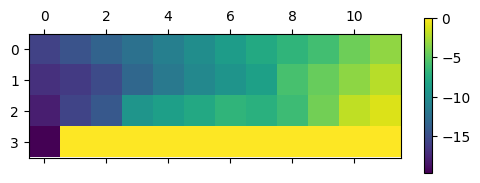

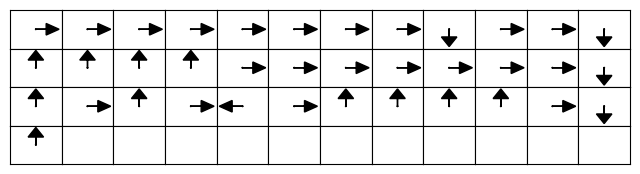

In [11]:
def n_step_SARSA_Q(env: base_env, n_steps = 5, N = 1, GAMMA = 1, ALPHA = 0.01):

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        t = 0
        state           = env.reset()    
        action          = env.sample_action(state, use_Qsa=True)
        mem = [state]
        actions = [action]
        rews = [-1000]  # dummy reward R_0 so next is R_{t+1}
        T = float("inf")
        while True:
            if t < T:
                state_prime, reward, done   = env.step(action)
                mem.append(state_prime)
                rews.append(reward)
                if done:
                    T = t + 1
                else:
                    action  = env.sample_action(state_prime, use_Qsa=True)
                    actions.append(action)
            tau = t - n_steps + 1
            if tau >= 0:
                # add +1 to end range to include it.
                G = sum([GAMMA**(i-tau-1)*rews[i] for i in range(tau+1, min(tau+n_steps,T) + 1)])
                if tau + n_steps < T:
                    G += GAMMA**n_steps*env.Qsa[mem[tau+n_steps]][actions[tau+n_steps]]
                SA_tau = mem[tau] + (actions[tau],)
                env.Qsa[SA_tau] = env.Qsa[SA_tau]+ ALPHA*(G - env.Qsa[SA_tau])
              
                #tq_iter.set_postfix(eps=env.eps, s = s)
            t += 1
            
            if tau == T - 1:
                break
    return

n_step_SARSA_Q(env_nSARSA_Q, n_steps = 5, N = 2000, GAMMA = 1, ALPHA = 0.01)

c = plt.matshow(env_nSARSA_Q.Qsa.max(-1).reshape(4,12))
plt.colorbar(c)

env_nSARSA_Q.policy_update_whole(use_Qsa = True)
env_nSARSA_Q.policy[37:] *= 0
plot_cliff_walking(env_nSARSA_Q.policy, figsize=(8,2))


# n-step SARSA using improtance sampling
1.  This shit (OG METHOD) does not work.
    
    Q values blow up because of high variance... 
    
    _ive spend too much time one this._
2.  Added regularization ~
    $$\bar\rho^t = \frac{\rho^t}{\sum_0^{t}\rho^t}$$
3. Reduced initial Q values to -100
4. Added questional choice for whe sum rho is zero

    R = RHO if normRHO == 0 else normRHO

    IDK why it does not 0/0 error xd, seem to work.

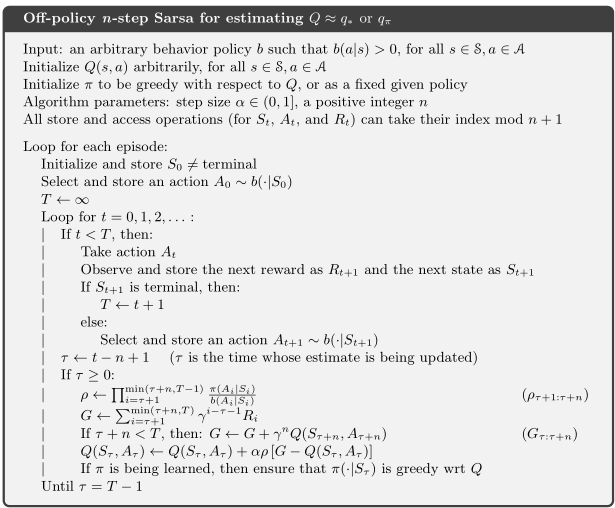

In [105]:

class base_env_importance_sampling(base_env):
    """
        Added sampling from behavior policy
    """
    def __init__(self, env_name, *args, eps=0.1, **kwargs):
        super().__init__(env_name, *args, eps=eps, **kwargs)
        self.policy_behavior = np.zeros_like(self.policy)

    def sample_action_behavior(self, state):
        policy = self.policy_behavior[state]
        return np.random.choice(self.actions, p= policy)
    
    def update_policy_state_based_on_Qsa(self,state, eps = None):
        eps = self.eps if eps is None else eps
        action = self.best_action(state) # with random tie break
        policy = np.ones_like(self.actions)*eps/(self.NUM_ACTIONS)
        policy[action] = (1 - eps + eps/(self.NUM_ACTIONS))
        self.policy[state] = policy
    
    
env_nSARSA_Q_IS = base_env_importance_sampling("CliffWalking-v0", eps=0.3)
# generate behavior policy thats exploratory
env_nSARSA_Q_IS.Qsa_init(action=1)

#env_nSARSA_Q_IS.Qsa[36,0] = 0
env_nSARSA_Q_IS.policy_update_whole(use_Qsa = True)
env_nSARSA_Q_IS.policy_behavior = env_nSARSA_Q_IS.policy.copy()
env_nSARSA_Q_IS.policy_behavior[36,[0,1]] = env_nSARSA_Q_IS.policy_behavior[36,[1,0]]
# switch learnable policy to random
env_nSARSA_Q_IS.Qsa_init(random=False, val = -100)
env_nSARSA_Q_IS.eps = 0
env_nSARSA_Q_IS.policy_update_whole(use_Qsa = True)
#plot_cliff_walking(env_nSARSA_Q_IS.policy_behavior, figsize=(8,2))
#plot_cliff_walking(env_nSARSA_Q_IS.policy, figsize=(8,2))
env_nSARSA_Q_IS.policy_behavior[36]

array([0.775, 0.075, 0.075, 0.075])

  0%|          | 0/15000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 15000/15000 [02:37<00:00, 95.11it/s, eps=0, maxRHO=3.95e+3] 


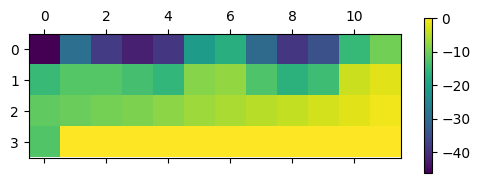

In [42]:
def n_step_SARSA_Q_IS(env: base_env_importance_sampling, n = 5, N = 1, GAMMA = 1, ALPHA = 0.01):
    store_Qs = {}
    tq_iter = tqdm(range(N))
    maxRHO = 0
    for z in tq_iter:
        t, T            = 0, float("inf")
        St           = env.reset()    
        At          = env.sample_action_behavior(St)
        states,actions,rewards= [St], [At], [-1000] # S_0, A_0, R_0
        normRHO = 0
        while True:
            if t < T:
                St1, Rt1, St1Terminal   = env.step(At)  # S_{t+1}, R_{t+1}
                states.append(St1);rewards.append(Rt1)
                if St1Terminal:
                    T = t + 1 # last added S_{t+1} is terminal
                else:
                    At1  = env.sample_action_behavior(St1)
                    actions.append(At1)
                    At = At1
            tau = t - n + 1 
            if tau >= 0:
                RHO = 1
                for i in range(tau+1, min(tau+n,T-1) + 1):
                    SAi = states[i] + (actions[i],)
                    RHO *= env.policy[SAi]/env.policy_behavior[SAi]
                    if RHO == 0: break
                maxRHO = max(maxRHO,RHO)
                normRHO += RHO
                if RHO : # else env.Qsa[SA_tau] += 0 -> no point updating
                    G = sum([GAMMA**(i-tau-1)*rewards[i] for i in range(tau+1, min(tau+n,T) + 1)])
                    if tau + n < T:
                        SAtn = states[tau+n] + (actions[tau+n],)
                        G += (GAMMA**n)*env.Qsa[SAtn]
                    SA_tau = states[tau] + (actions[tau],)
                    R = RHO if normRHO == 0 else normRHO #min(1, normRHO)
                    env.Qsa[SA_tau] = env.Qsa[SA_tau] + ALPHA*RHO/R*(G - env.Qsa[SA_tau])      # added RHO
                    env.update_policy_state_based_on_Qsa(states[tau],eps = 0)               # new
            t += 1
            if tau == T - 1:
                break 
        env.env_iters += 1
        if env.env_iters % (N//10) == 0:
            store_Qs[env.env_iters] = env.Qsa.max(-1).reshape(4,12)

        tq_iter.set_postfix(eps=env.eps, maxRHO = maxRHO)
    store_Qs[env.env_iters] = env.Qsa.max(-1).reshape(4,12)
    return store_Qs

store_Qs = n_step_SARSA_Q_IS(env_nSARSA_Q_IS, n = 5, N = 15000, GAMMA = 0.99, ALPHA = 0.05)

asd =env_nSARSA_Q_IS.Qsa.max(-1)
asd[37:]*=0
c = plt.matshow(asd.reshape(4,12))
plt.colorbar(c)

#env_nSARSA_Q_IS.policy_update_whole(use_Qsa = True)
#env_nSARSA_Q_IS.policy[37:] *= 0
#plot_cliff_walking(env_nSARSA_Q_IS.policy, figsize=(8,2))

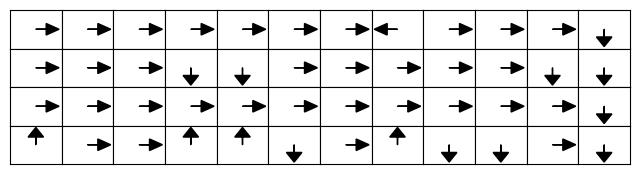

In [45]:
plot_cliff_walking(env_nSARSA_Q_IS.policy, figsize=(8,2))

[1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, 13500, 15000]

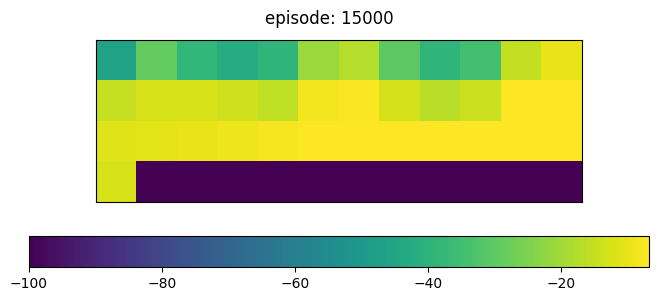

In [46]:
from IPython.display import HTML
display(HTML(anim(store_Qs).to_html5_video()))
list(store_Qs)

##  n-step Tree Backup

*   This method extends _expected_ SARSA algorithm to n-steps
*   for n=1 we have classic 1-step expected SARSA
    $$G_{t:t+1} = R_{t+1} + \gamma \sum_a \pi(a|S_{t+1})Q_t(S_{t+1},a)$$
*   when we introduce n-steps, classical n-step approach is to add rewards for first $n$ steps and bootstrap future rewards.

    we can calculate expectation over each time step, except actual intermediate __reward is known__ form a trajectory

    this means that we have to bootstrap __only__ Q values of actions that were not taken

    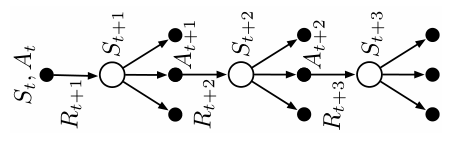

*   For example if n = 2:
    *   For expected reward we should do a sum weighted by transition probabilities.

        One of actions ($A_{t+1}$) was taken, and remaining not.
        
        We know that:
        $$\pi(A_{t+1}|S_{t+1}) + \sum_{a \neq A_{t+1}} \pi(a|S_{t+1})  = 1$$
    *   Known outcome is 
        $$Q(S_{t+1},A_{t+1}) = G_{t+1:t+2} = R_{t+2} + \text{expected future reward}(S_{t+2})$$
        We have to bootstrap remaining rewards $Q(S_{t+1},a \neq A_{t+1})$ from actions that were not taken 

    *   Expectation for this layer is (undiscounted)
        $$G_{t:t+2} = R_{t+1} +\pi(A_{t+1}|S_{t+1}) \cdot Q(S_{t+1},A_{t+1}) + \sum_{a \neq A_{t+1}} \pi(a|S_{t+1}) \cdot Q(S_{t+1},a)$$
        
    *   overall expression is the following (with discounting):
         $$G_{t:t+2} =  R_{t+1} + \gamma  \sum_{a \neq A_{t+1}} \pi(a|S_{t+1}) \cdot Q(S_{t+1},a) + \gamma \ \pi(A_{t+1}|S_{t+1}) \cdot G_{t+1:t+2}$$

*   For arbitrary $n$:
    $$\boxed{G_{t:t+n} =  R_{t+1} + \gamma  \sum_{a \neq A_{t+1}} \pi(a|S_{t+1}) \cdot Q(S_{t+1},a) + \gamma \ \pi(A_{t+1}|S_{t+1}) G_{t+1:t+n}}$$
***

So algorithm for for n=2 __is done in reverse__:
*    step = 2
     *    gather last expected future rewards 
     $$r_{t+2} = \sum_a \pi(a|S_{t+2}) \cdot Q(S_{t+2},a)$$
     *    discount and add to immediate reward
     $$G_{t+1:t+2} = R_{t+2} + \gamma r_{t+2} = R_{t+2} + \gamma \sum_a \pi(a|S_{t+2}) \cdot Q(S_{t+2},a)$$
     * if $t+2$ is terminal then $G_{t+1:t+2} = R_{t+2}$ (because you dont take actions form terminal state, $\pi(\cdot|S_{t+2}) = 0$ )
*    step = 1
     *    Calc estimated future rewards

          Observed reward
          $$r_{t+1}^A = \pi(A_{t+1}|S_{t+1}) \cdot G_{t+1:t+2}$$
          Bootstrapped rewards
          $$r_{t+1}^a = \sum_{a\neq A_{t+1}} \pi(a|S_{t+1}) \cdot Q(S_{t+1},a)$$
     * add immediate and expected future rewards
     $$G_{t+0:t+2} = R_{t+1} + \gamma \underbrace{\left[ r_{t+1}^a  + r_{t+1}^A \right]}_{\mathbb{E}[r_{t+1}]}= R_{t+1} + \gamma \left[ \sum_{a\neq A_{t+1}} \pi(a|S_{t+1}) \cdot Q(S_{t+1},a)  + \pi(A_{t+1}|S_{t+1}) \cdot G_{t+1:t+2} \right]$$


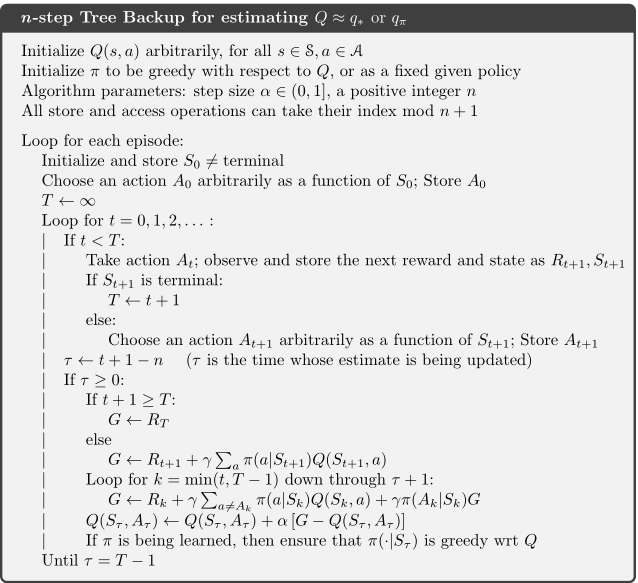

NOTE: may be something fu(n)cky happend with my base_env class. making actions based on policy "looks like" performs better than on action values.

And thats what i do:

*   Get last expected reward:

    $G_{t+1:t+2} = R_{t+2} + \gamma \sum_a \pi(a|S_{t+2}) \cdot Q(S_{t+2},a) \text{ or } R_{t+2}$
* $G_{t:t+2} =  G_{t+1:t+2} \cdot \pi(A_{t+1}|S_{t+1})$
* $G_{t:t+2} =  G_{t:t+2} +  \sum_{a\neq A_{t+1}} \pi(a|S_{t+1}) \cdot Q(S_{t+1},a)$
* $G_{t:t+2} = G_{t:t+2} + R_{t+1}$


In [95]:
env_bTree = base_env("CliffWalking-v0", eps=0)
env_bTree.Qsa_init(random=True)
env_bTree.Qsa[37:] *= 0
# env_bTree.Qsa[36] = [1,0,0,0]
env_bTree.policy_update_whole(use_Qsa = True)

100%|██████████| 10400/10400 [00:43<00:00, 241.46it/s]


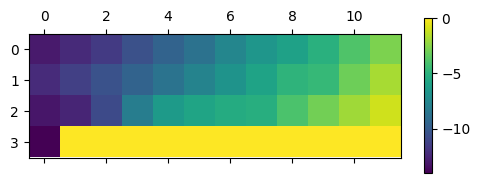

In [103]:
def n_step_Tree_Backup(env: base_env, n = 5, N = 1, GAMMA = 1, ALPHA = 0.01):

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        t = 0
        St           = env.reset()    
        At          = env.sample_action(St, use_Qsa=False)
        states,actions,rewards = [St],[At],[-1000]
        T = float("inf")
        while True:
            if t < T:
                St1, Rt1, St1_terminal   = env.step(At)
                states.append(St1)
                rewards.append(Rt1)
                if St1_terminal:
                    T = t + 1
                else:
                    At1  = env.sample_action(St1, use_Qsa=False)
                    actions.append(At1)
                    At = At1
            tau = t - n + 1
            if tau >= 0:
                if t + 1 >= T:  # terminal, dont calc expectation
                    G = rewards[T]
                else:   
                    St1,Rt1 = states[t+1],rewards[t+1]   # not terminal calc expectation
                    G = Rt1 + GAMMA* np.dot(env.policy[St1], env.Qsa[St1])
                for k in range(min(t,T-1),tau + 1 -1,-1):   # start going backwards
                    Sk, Ak = states[k], actions[k]  # 
                    G *= GAMMA* env.policy[Sk][Ak]  # known future reward
                    G += rewards[k]                 # add  insta reward
                    a = [action for action in env.actions if action != actions[k]]
                    G += GAMMA *np.dot(env.policy[Sk,a], env.Qsa[Sk,a]) # part of bootstrapped future rewards
                    
                SA_tau = states[tau] + (actions[tau],)
                env.Qsa[SA_tau] = env.Qsa[SA_tau]+ ALPHA*(G - env.Qsa[SA_tau])
                #tq_iter.set_postfix(eps=env.eps, s = s)
                env.update_policy_via_Qsa(states[tau])
            t += 1
            
            if tau == T - 1:
                break
    return

n_step_Tree_Backup(env_bTree, n = 4, N = 10400, GAMMA = 0.99, ALPHA = 0.01)

c = plt.matshow(env_bTree.Qsa.max(-1).reshape(4,12))
plt.colorbar(c)

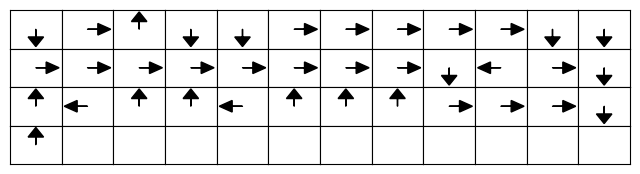

In [102]:
#env_bTree.policy_update_whole()
env_bTree.policy[37:] *= 0
plot_cliff_walking(env_bTree.policy, figsize=(8,2))

## n-step $Q(\sigma)$


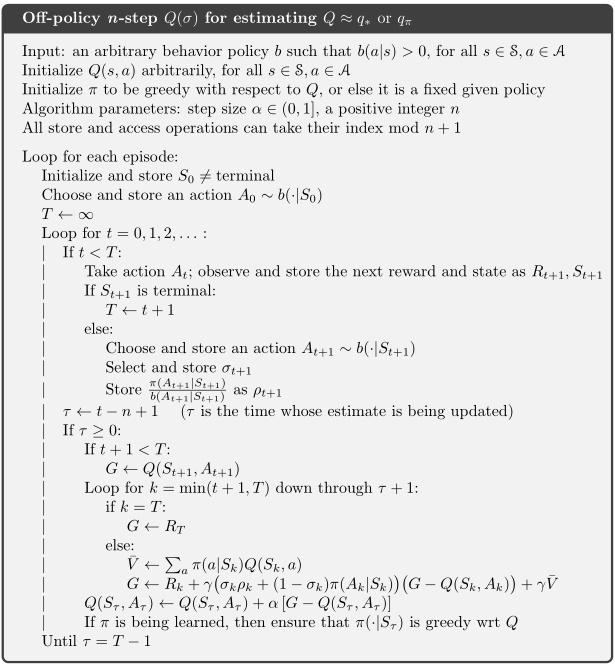

In [149]:
env_nQsigma = base_env_importance_sampling("CliffWalking-v0", eps=0.6)
# b pol
env_nQsigma.Qsa_init(action=1)
env_nQsigma.policy_update_whole(use_Qsa = True)
env_nQsigma.policy_behavior             = env_nQsigma.policy.copy()
env_nQsigma.policy_behavior[36,[0,1]]   = env_nQsigma.policy_behavior[36,[1,0]]
# tar pol
env_nQsigma.eps = 0
env_nQsigma.Qsa_init(random=False, val = -10)   
env_nQsigma.policy_update_whole(use_Qsa = True)

env_nQsigma.policy_behavior[36],env_nQsigma.policy[36]

(array([0.55, 0.15, 0.15, 0.15]), array([0., 0., 1., 0.]))

100%|██████████| 1000/1000 [00:34<00:00, 28.95it/s, eps=0]


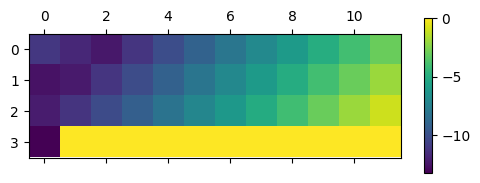

In [150]:
def n_step_Q_sigma(env: base_env_importance_sampling, n = 5, N = 1,sigma = 0.5, GAMMA = 1, ALPHA = 0.01):
    store_Qs = {}
    tq_iter = tqdm(range(N))
    for z in tq_iter:
        t, T        = 0, float("inf")
        St          = env.reset()    
        At          = env.sample_action_behavior(St)
        states,actions,rewards,rhos,sigmas = [St],[At],[-1e3],[1],[sigma]
        while True:
            if t < T:
                St1, Rt1, St1Terminal   = env.step(At)  # S_{t+1}, R_{t+1}
                states.append(St1);rewards.append(Rt1)
                if St1Terminal:
                    T = t + 1 # last added S_{t+1} is terminal
                else:
                    At1  = env.sample_action_behavior(St1)
                    actions.append(At1);sigmas.append(sigma)
                    SAt1 = St1 + (At1,)
                    rhos.append(env.policy[SAt1]/env.policy_behavior[SAt1])
                    At = At1
            tau = t - n + 1 
            if tau >= 0:
                if t+1<T:
                    G = env.Qsa[SAt1] # hopefully it persists from definition place

                for k in range(min(t+1,T),tau + 1 - 1, -1): #incl 'to' bound
                    if k == T:
                        G = rewards[T]
                    else:
                        Sk = states[k]
                        SAk = Sk + (actions[k],)
                        
                        Vbar = np.dot(env.policy[Sk],env.Qsa[Sk])
                        G = GAMMA*(sigmas[k]*rhos[k] + (1-sigmas[k])*env.policy[SAk])*(G - env.Qsa[SAk])
                        G += rewards[k]+ GAMMA*Vbar

                SA_tau = states[tau] + (actions[tau],)
                env.Qsa[SA_tau] = env.Qsa[SA_tau] + ALPHA*(G - env.Qsa[SA_tau])      # added RHO
                env.update_policy_state_based_on_Qsa(states[tau],eps = 0)               # new
            t += 1
            if tau == T - 1:
                break 
        env.env_iters += 1
        if N>= 10 and env.env_iters % (N//10) == 0:
            store_Qs[env.env_iters] = env.Qsa.max(-1).reshape(4,12)

        tq_iter.set_postfix(eps=env.eps)
    store_Qs[env.env_iters] = env.Qsa.max(-1).reshape(4,12)
    return store_Qs


store_Qs = n_step_Q_sigma(env_nQsigma, n = 5, N = 1000,sigma = 0.5, GAMMA = 1, ALPHA = 0.01)

asd =env_nQsigma.Qsa.max(-1)
asd[37:]*=0
c = plt.matshow(asd.reshape(4,12))
plt.colorbar(c)

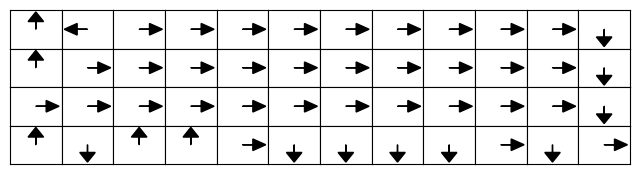

In [151]:
#env_bTree.policy[37:] *= 0
plot_cliff_walking(env_nQsigma.policy, figsize=(8,2))